# The HP Filter
Smoothing time series data is useful in many economic situations. The main idea is to try to separate a "trend" from a "cycle." The smoothed series should not differ too much from the actual data. This is done through a choice of parameters in the filter. 

 Suppose we have $T$ observations on the log of some time series $y_{t}$ for $t=1,2, \ldots , T$, where $y_{t}$ consists of a trend term, $\tau_{t}$, and a cyclical component, $c_{t}$, so that $y_{t} = \tau_{t} + c_{t}$. 

The HP filter finds $\{\tau_{t}\}$ that solves

$$ 
\min_{\tau} \Big(\sum_{t=1}^{T} (c)^2 + \lambda \sum_{t=1}^{T} [(\tau_{t}-\tau_{t-1})-(\tau_{t-1}-\tau_{t-2})]^2  \Big), 
$$
or, rewriting
$$ 
 \min_{\tau} \Big(\sum_{t=1}^{T} (y_{t}-\tau_{t})^2 + \lambda \sum_{t=1}^{T} [(\tau_{t}-\tau_{t-1})-(\tau_{t-1}-\tau_{t-2})]^2  \Big),
$$


where $\lambda$ is the ``smoothness penalty.'' Note that as $\lambda \rightarrow 0$, we just have the series, $y_{t}$, itself and $\lambda \rightarrow \infty$ is just a regression on a linear trend (second difference is $0$). Here is a Python implementation:

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from tabulate import tabulate
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters
import matplotlib.ticker as ticker
###from statsmodels.tsa.x13 import x13_arima_analysis
import sys
### Some libraries for web scraping (BLS revisions)
import requests
from bs4 import BeautifulSoup
import time

start_time = time.time()

pd.set_option('display.max_rows', None)

my_colors = ["#00688b",
             "#cd3333",
             "#6c8b3d", 
             "cornflowerblue",
             "#cd6600",
             "#8b2323",
             "#5d478b",
             "red"]
plt.rcParams['axes.prop_cycle'] = cycler(color = my_colors)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
#plt.rcParams['axes.ymargin'] = 0.0
plt.rcParams["figure.figsize"] = (10.5,6.5)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.framealpha'] = None
plt.rcParams["legend.loc"] = 'best' 
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['axes.titlecolor'] = '#3333B3FF'
plt.rcParams['lines.linewidth'] = 3

plt.rcParams['figure.subplot.left'] = 0
plt.rcParams['figure.subplot.bottom'] = 0
plt.rcParams['figure.subplot.right'] = 1
plt.rcParams['figure.subplot.top'] = 1

def crosscorr(datax, datay, lag=0):
   return datax.corr(datay.shift(lag))

def NBER(start_date):
    ax2 = ax.twinx()
    Recessions = monthly['recessiondates'][monthly.index >= start_date]
    ax2.fill_between(Recessions.index,
                     Recessions,
                     step="pre",
                     color="gray",
                     alpha=0.2)
    ax2.get_yaxis().set_visible(False)
    return ax2

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

def day_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    return f'{label.month} {label.day}'

def month_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month = month + '\n' + f'{label.year}'
    #else:
    #    month = ""
    return month

def quarter_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month = f'Q1\n{label.year}'
    if month == 'Apr':
        month = 'Q2'
    if month == 'Jul':
        month = 'Q3'
    if month == 'Oct':
        month = 'Q4'
    return month


Now we will read in some data.

In [34]:
### Quarterly

FREDmap = {
    'GDPC1': 'real_gdp'
    }

quarterly = pdr.DataReader(list(FREDmap.keys()), 'fred', datetime.datetime(1800,1,1))
quarterly.rename(columns = FREDmap, inplace = True)

quarterly.to_pickle('quarterly.pickle')


In [35]:
quarterly['real_gdp'].tail()

DATE
2023-07-01    22780.933
2023-10-01    22960.600
2024-01-01    23053.545
2024-04-01    23223.906
2024-07-01    23386.733
Name: real_gdp, dtype: float64

In [36]:
def EconLineGraph(dataframe = None,
                  series = None,
                  labels = None,
                  title = None,
                  subtitle = None,
                  source = None,
                  ylabel = None,
                  start_date = None,
                  end_date = None,
                  graph_name = None,
                  recessions = False,
                  logscale = False,
                  ylines = None,
                  yzero = False):
   """For creating line graphs from a data frame

    Inputs:
    -------
    dataframe : dataframe
         The dataframe containing the data to be plotted                           
    series : vector of text
         The "names" of the variables to be plotted
    labels : vector of text
         The labels (descriptions) of each variable
    title : text string
         Title for the figure
    subtitle : text string
         A "title" which appears at top left of the figure
    source : text string
         The source for the data; appears at bottom right of the figure
    ylabel : text string
         Text that appears beside the y axis
    start_date : string
         The first date to appear in the figure (end date is always the last available
         observation). String as 'yyyy-mm-dd'.
    graph_name : text string
         The basename for the graph files. Both pdf and png files are produced
    recessions : logical
         If True, then include NBER business cycle recession shading from 
         the dataframe "monthly"
    """
    
   if start_date == None:
      df = dataframe[series].dropna(how = 'all')
      start_date = df.first_valid_index()
   else:
      df = dataframe.loc[start_date:][series].dropna(how = 'all')

   fig, ax = plt.subplots()
       
   if logscale:
      ax.set_yscale('log')
      ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%.0f"))
      ax.yaxis.set_minor_formatter(plt.FormatStrFormatter("%.0f"))

   if recessions:
      ax.plot(df, clip_on = False)
   else:
      df.plot(ax = ax, clip_on = False)

   if yzero is True:
      plt.axhline(y = 0, color = '#a0a0a0', linewidth = 0.75, label = None)
   else:
      if ylines is not None:
         if len(ylines) == 1:
            df[str(ylines)] = ylines[0]
            df[str(ylines)].loc[start_date:].plot(ax = ax, clip_on = False, color = '#a0a0a0', linewidth = 1.0)
         else:
            for i in ylines:
               df[str(i)] = i
               df[str(i)].loc[start_date:].plot(ax = ax, clip_on = False, color = '#a0a0a0', linewidth = 1.0)
      
   if title is not None:
      ax.set_title(title)

   if subtitle is not None:
      ax.set_title(subtitle,
                   loc = 'left',
                   color = 'black',
                   size = 'medium')

   if ylabel is not None:
      ax.set_ylabel(ylabel)

   if labels is not None:
      #if ax.get_legend() != None:
      ax.legend(labels)
      #ax.legend().set_zorder(2)
   else:
      if ax.get_legend() != None:
         ax.legend().set_visible(False)

   if source is not None:
      ax.set_xlabel('Source: ' + source,
                    horizontalalignment='right',
                    x=1.0)
   else:
      ax.set_xlabel('')

   if recessions:
      ax2 = ax.twinx()
      Recessions = monthly['recessiondates'][monthly.index >= start_date]
      ax2.fill_between(Recessions.index,
                       Recessions,
                       step="pre",
                       color="gray",
                       alpha=.2)
      ax2.get_yaxis().set_visible(False)
      ax2.set_ymargin(0) 

   fig.savefig('pyfigs/pdf/' + graph_name + '.pdf', bbox_inches='tight', pad_inches=0.25)
   fig.savefig('pyfigs/png/' + graph_name + '.png', bbox_inches='tight', pad_inches=0.25)
   



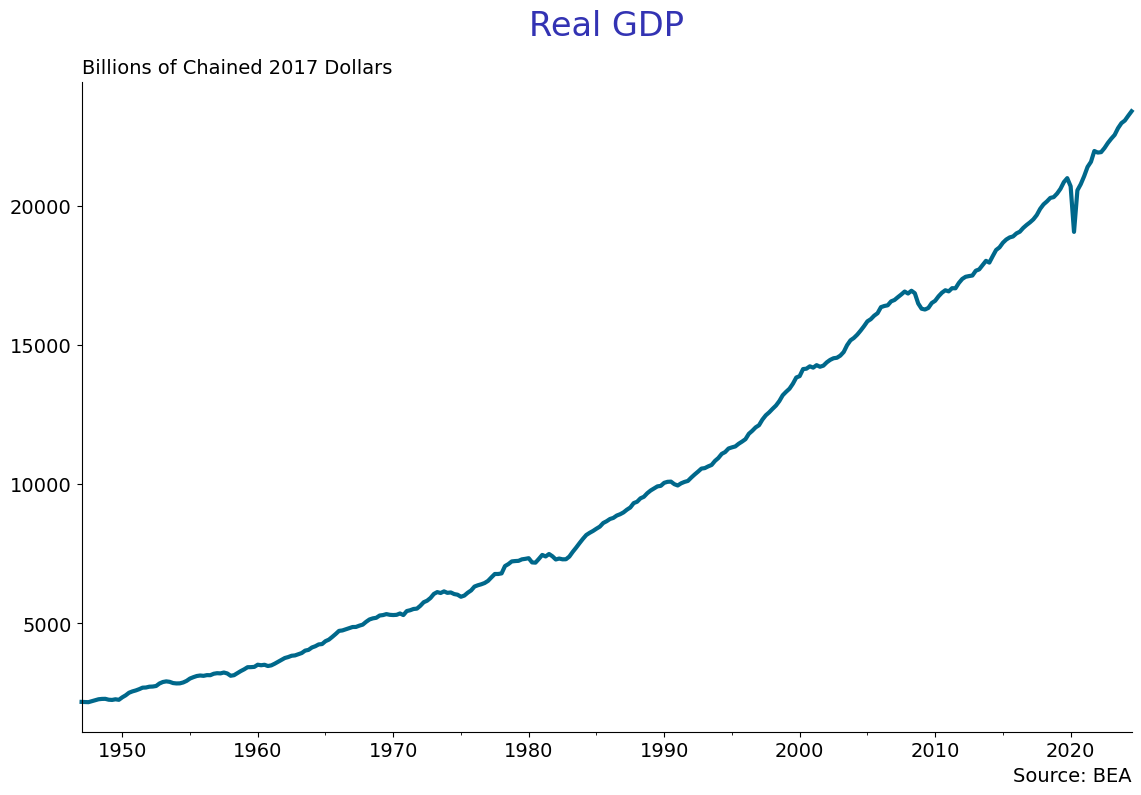

In [37]:
EconLineGraph(dataframe = quarterly,
              series = ['real_gdp'],
              title = 'Real GDP\n',
              subtitle = 'Billions of Chained 2017 Dollars',
              source = 'BEA',
              start_date = '1947-01-01',
              graph_name = 'log_real_gdp',
              logscale= False)


Take the log of real gdp and create the hpfilter, using 1600 for $\lambda$.

In [38]:
quarterly['lrgdp'] = np.log(quarterly['real_gdp'])
hpcycle_gdp, hptrend_gdp = hpfilter(quarterly['lrgdp'].dropna(), lamb=1600)
quarterly['hptrend_gdp'] = hptrend_gdp
quarterly['hpcycle_gdp'] = hpcycle_gdp

Now graph the real gdp series and the hp trend. 

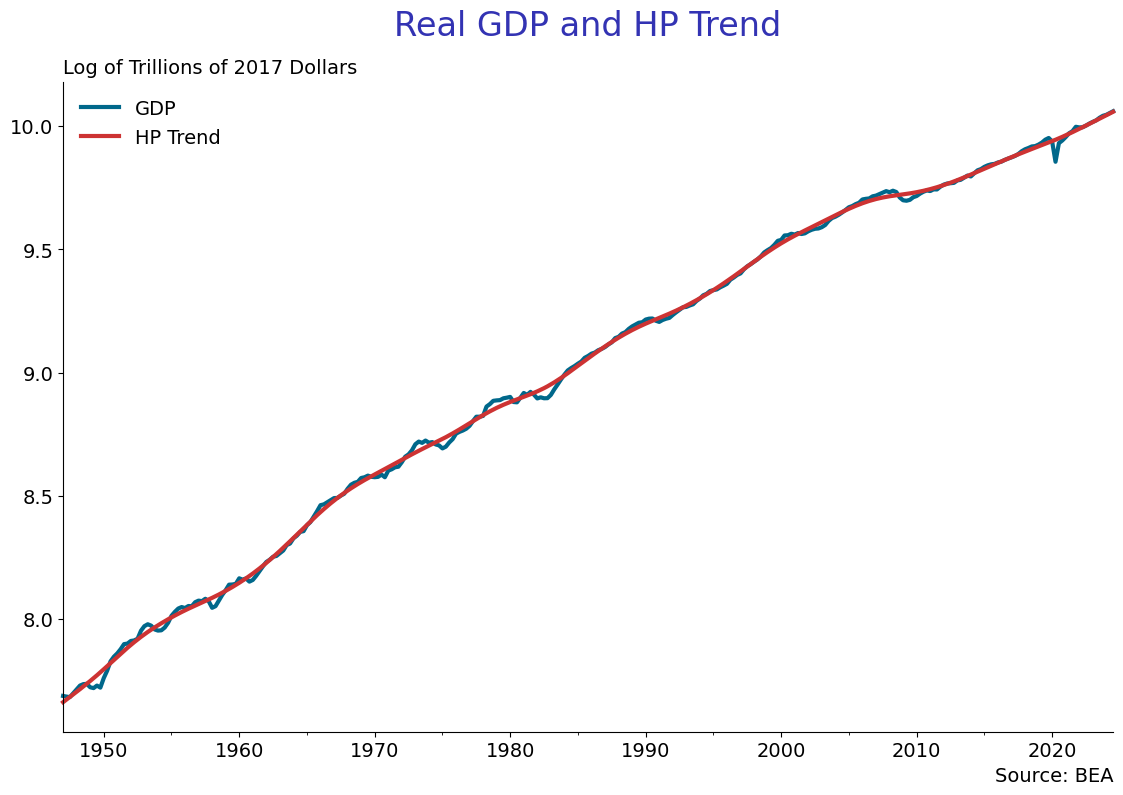

In [39]:
EconLineGraph(dataframe = quarterly,
          series = ['lrgdp', 'hptrend_gdp'],
          labels = ['GDP', 'HP Trend'],
          title = 'Real GDP and HP Trend\n',
          subtitle = 'Log of Trillions of 2017 Dollars',
          source = 'BEA',
          start_date = '1947-01-01',
          graph_name = 'hp_log_real_gdp',
          logscale= False)

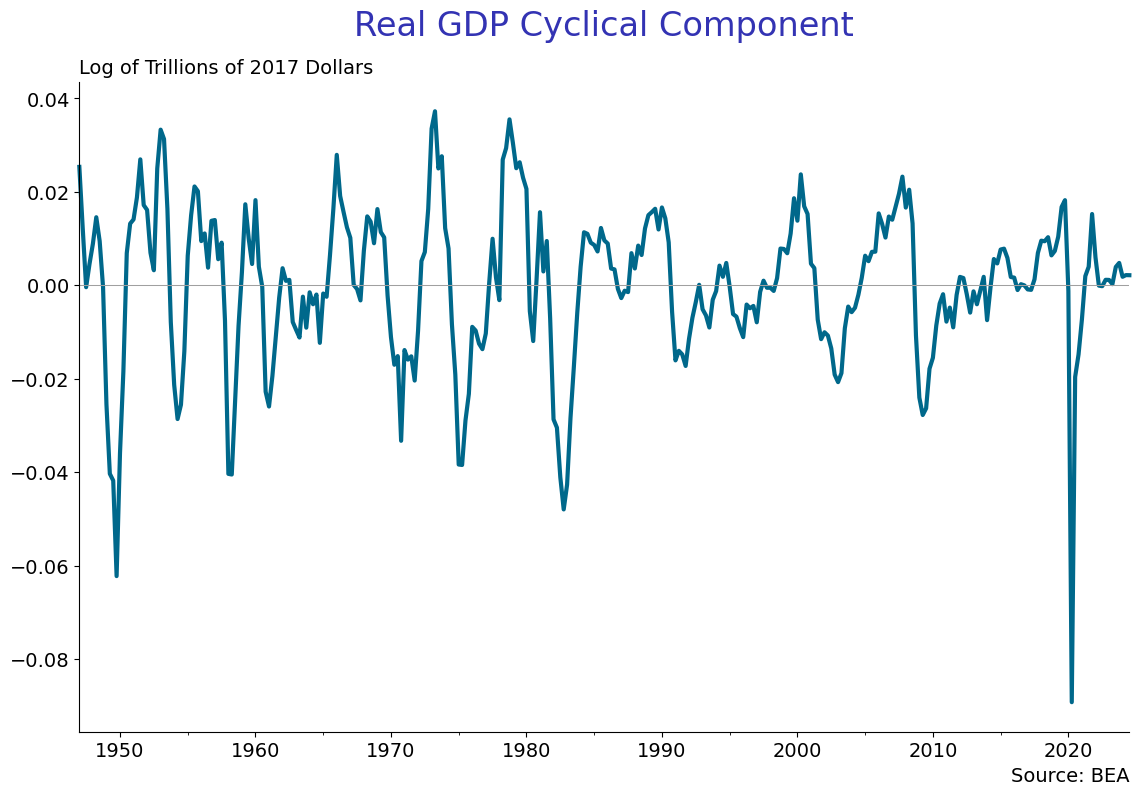

In [40]:
EconLineGraph(dataframe = quarterly,
          series = ['hpcycle_gdp'],
          title = 'Real GDP Cyclical Component\n',
          subtitle = 'Log of Trillions of 2017 Dollars',
          source = 'BEA',
          start_date = '1947-01-01',
          graph_name = 'hp_cycle_log_real_gdp',
          yzero = True,
          logscale= False)

Homework #1: 

(A) Use a very large number for $\lambda$, like 16000000000 and see the trend and cycle. Explain what is going on. Next plot the cylical component for the two different $\lambda$'s and comment on the difference.  

(B) Download GDPCA from FRED. This is annual real GDP back to 1929. Should you use $\lambda=1600$? Why or why not? If not, what value should you use? Why?